In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



In [82]:
# Cargar el dataset
data = pd.read_csv("Temp_Asu20092021.csv")

# Convertir la columna 'Fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Establecer la columna 'Fecha' como índice
data.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019 en adelante
data = data[data.index.year >= 2019]

# Eliminar filas con valores faltantes
data.dropna(inplace=True)


In [83]:
# Resamplear el conjunto de datos a intervalos diarios y calcular la temperatura máxima diaria
daily_max_temperatures = data['Temperatura'].resample('D').max()

salida= daily_max_temperatures .shift(-1)

# Definir características (features) y variable objetivo (target)
X = daily_max_temperatures.values[:-1]  # Puedes agregar más características según sea necesario
y = salida.values[:-1]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,1))

# Dividir los datos en conjuntos de entrenamiento y validación
train_indices = (daily_max_temperatures.index.year <= 2020)[:-1]
val_indices = (daily_max_temperatures.index.year == 2021)[:-1]

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]


# Definir el modelo de regresión Ridge
ridge = Ridge()

# Definir la cuadrícula de parámetros para GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularización L2
}



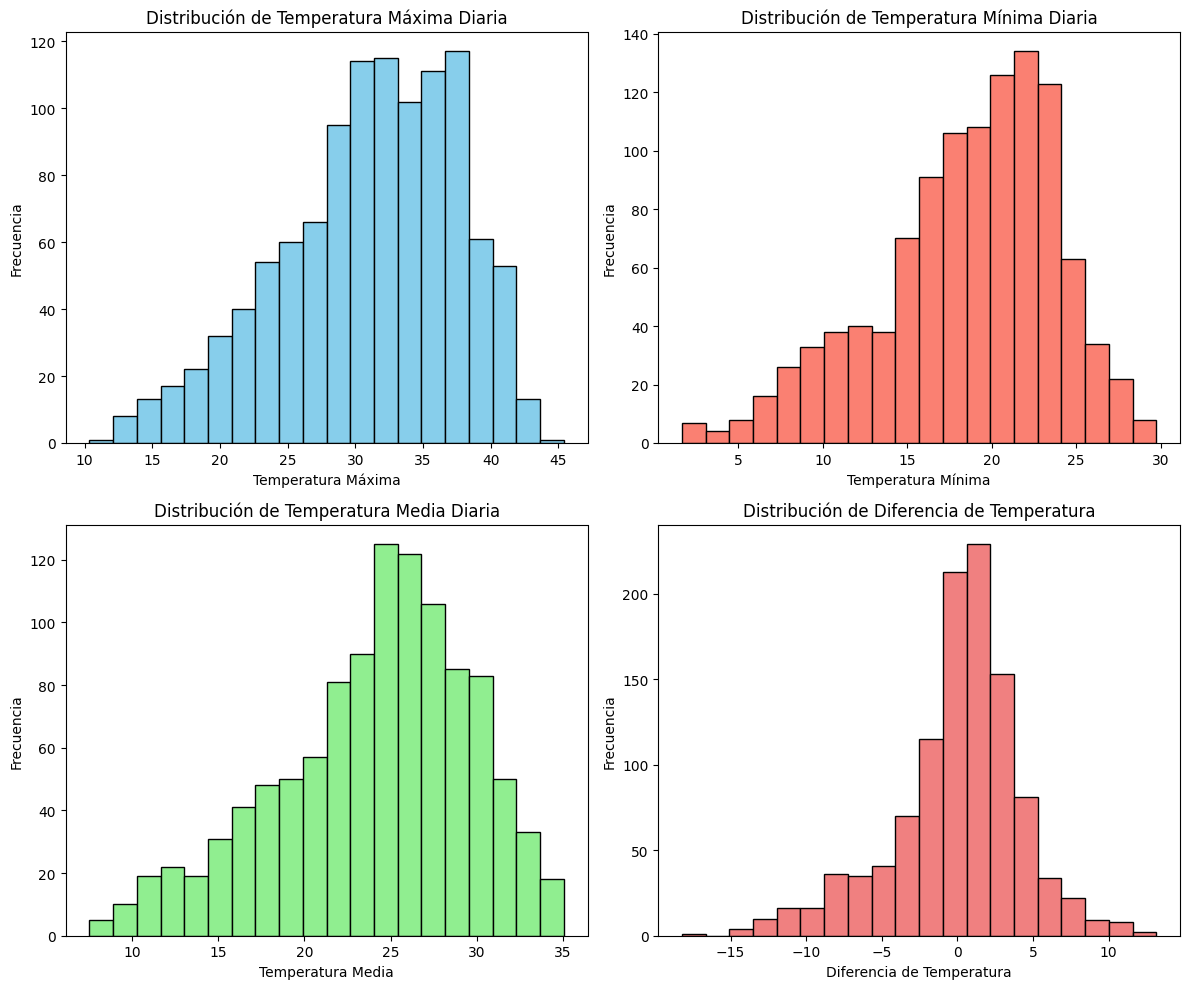

In [84]:
# Crear nuevas variables
data['Max_Temperature_Day'] = data['Temperatura'].resample('D').max()
data['Min_Temperature_Day'] = data['Temperatura'].resample('D').min()
data['Mean_Temperature_Day'] = data['Temperatura'].resample('D').mean()
data['Temp_Difference'] = daily_max_temperatures.diff()  # Diferencia entre días consecutivos
data['Month'] = data.index.month  # Variable de mes

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Actualizar X con las nuevas variables
X = data[['Max_Temperature_Day', 'Min_Temperature_Day', 'Mean_Temperature_Day', 'Temp_Difference', 'Month']][:-1].values
y = salida.values[:-1]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Plotear histogramas para cada nueva variable
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histograma de temperaturas máximas diarias
axes[0, 0].hist(data['Max_Temperature_Day'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribución de Temperatura Máxima Diaria')
axes[0, 0].set_xlabel('Temperatura Máxima')
axes[0, 0].set_ylabel('Frecuencia')

# Histograma de temperaturas mínimas diarias
axes[0, 1].hist(data['Min_Temperature_Day'], bins=20, color='salmon', edgecolor='black')
axes[0, 1].set_title('Distribución de Temperatura Mínima Diaria')
axes[0, 1].set_xlabel('Temperatura Mínima')
axes[0, 1].set_ylabel('Frecuencia')

# Histograma de temperatura media diaria
axes[1, 0].hist(data['Mean_Temperature_Day'], bins=20, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribución de Temperatura Media Diaria')
axes[1, 0].set_xlabel('Temperatura Media')
axes[1, 0].set_ylabel('Frecuencia')

# Histograma de diferencia de temperatura diaria
axes[1, 1].hist(data['Temp_Difference'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Distribución de Diferencia de Temperatura')
axes[1, 1].set_xlabel('Diferencia de Temperatura')
axes[1, 1].set_ylabel('Frecuencia')

# Ajustar los espacios entre los gráficos
plt.tight_layout()
plt.show()



Fitting 3 folds for each of 5 candidates, totalling 15 fits


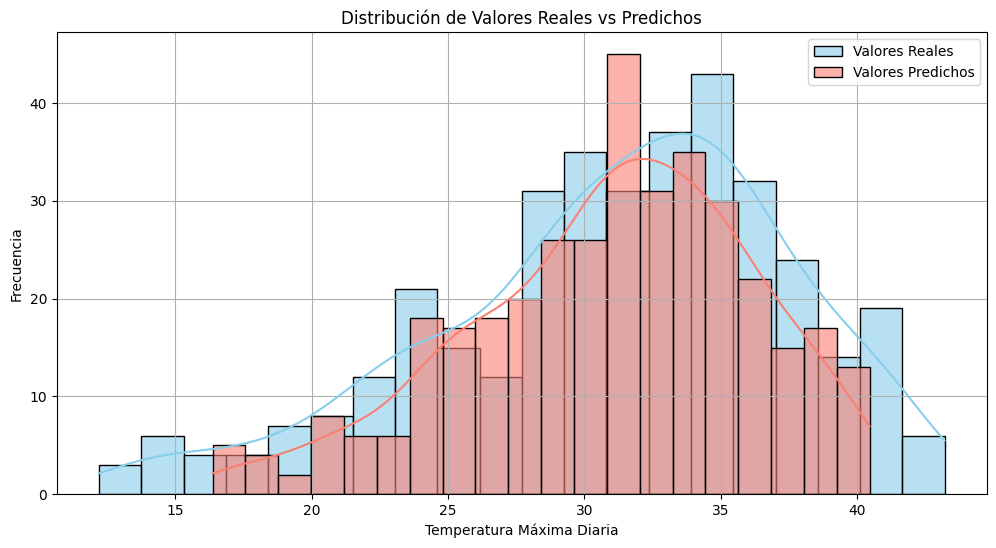

C:\Users\Mathias\AppData\Local\Temp\ipykernel_12748\1696482294.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--k', color='red')


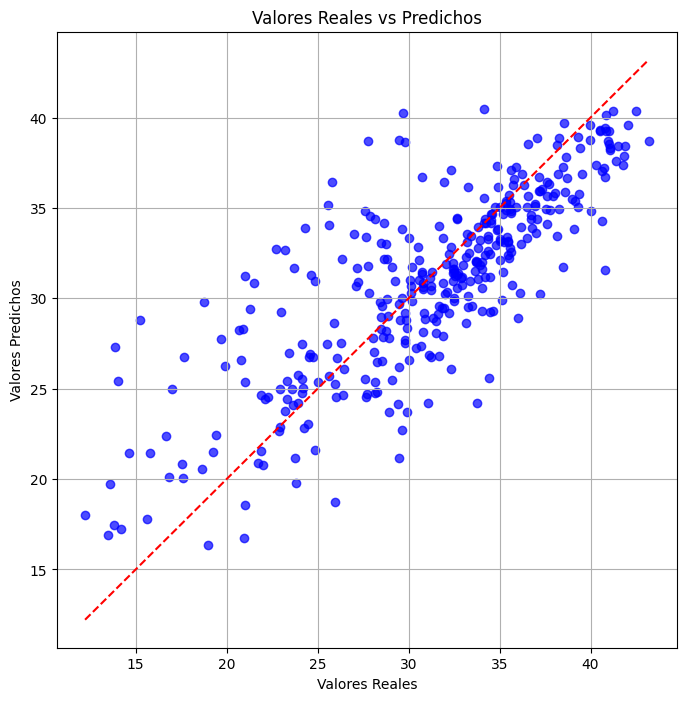

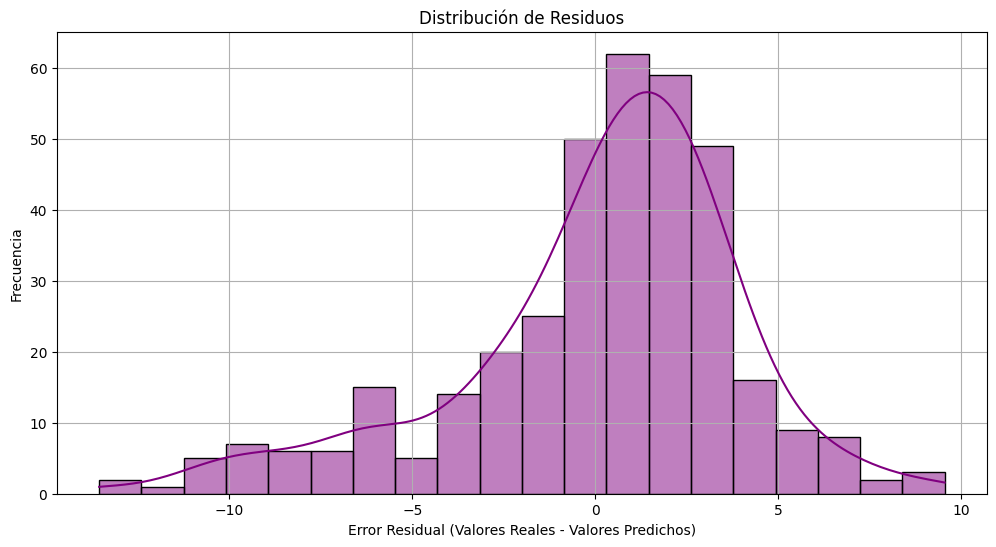

In [85]:


# Definir características (features) y variable objetivo (target)
X = data[['Max_Temperature_Day', 'Min_Temperature_Day', 'Mean_Temperature_Day', 'Temp_Difference']].values[:-1]
y = data['Max_Temperature_Day'].shift(-1).values[:-1]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y validación
train_indices = (data.index.year <= 2020)[:-1]
val_indices = (data.index.year == 2021)[:-1]

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

# Definir el modelo de regresión Ridge
ridge = Ridge()

# Definir la cuadrícula de parámetros para GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularización L2
}

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred = best_model.predict(X_val)

# Gráfico de histograma para valores reales y predichos
plt.figure(figsize=(12, 6))

# Histograma de valores reales
sns.histplot(y_val, bins=20, color='skyblue', kde=True, label='Valores Reales', alpha=0.6)

# Histograma de valores predichos
sns.histplot(y_pred, bins=20, color='salmon', kde=True, label='Valores Predichos', alpha=0.6)

# Configuración de gráficos
plt.title('Distribución de Valores Reales vs Predichos')
plt.xlabel('Temperatura Máxima Diaria')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de dispersión de valores reales vs predichos con línea de identidad
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.7, color='blue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--k', color='red')
plt.title('Valores Reales vs Predichos')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.show()

# Gráfico de residuos (error residual)
residuals = y_val - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=20, kde=True, color='purple')
plt.title('Distribución de Residuos')
plt.xlabel('Error Residual (Valores Reales - Valores Predichos)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


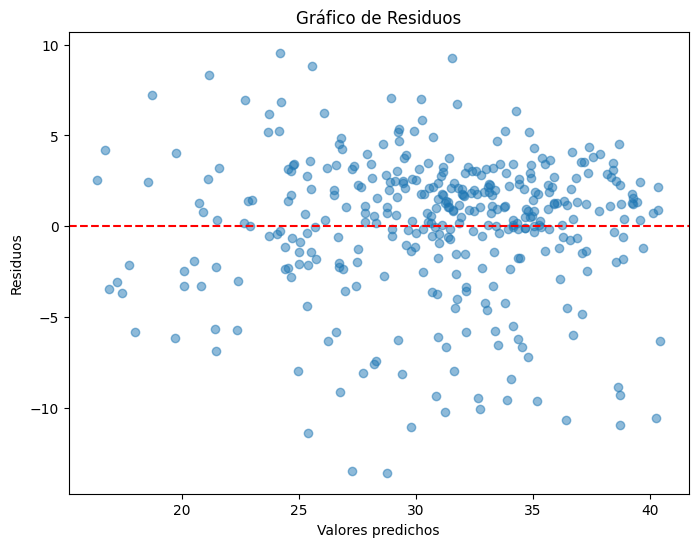

In [86]:
# Calcular residuos
residuals = y_val - y_pred

# Gráfico de residuos
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.show()
